In [1]:
# Load libraries 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import RandomizedSearchCV


In [2]:
# Mounting Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load cleaned data
denver_df=pd.read_excel(r"/content/drive/MyDrive/Wild Fire Data Science Competition/Final Data/Final Report/Denver.xlsx")
columbus_df = pd.read_excel(r"/content/drive/MyDrive/Wild Fire Data Science Competition/Final Data/Final Report/Columbus.xlsx")

# Filtering data frame to exclude observations where "Occurences" = 0 (this filtered df may or may not be needed)
denver_df_filtered = denver_df[denver_df['Occurences'] != 0]
columbus_df_filtered = columbus_df[columbus_df['Occurences'] != 0]

In [7]:
# Let's define the predictor variables that we'll use for each region. These variables were selected from the output of forward/backward selection from R. 

# denver_predictors = ['NDVI', 'SurfPS', 'Dust', 'SoilMoisture', "LAI",  'Canopy_h2o', 'Transpire', 'tempmin', 'humidity', 'precipprob', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir' , 'sealevelpressure' , 'visibility', 'solarradiation', 'uvindex', 'moonphase']
# columbus_predictors = ['Dust', 'SoilMoisture','Transpire', 'humidity', 'precipprob',  'snowdepth', 'sealevelpressure' , 'cloudcover', 'moonphase', 'confidence','WindVelocity']

denver_predictors_fb = ['NDVI','SurfPS', 'Dust','SoilMoisture', 'LAI', 'Canopy_h2o','Transpire','tempmin','dew', 'humidity','precipprob','snow','snowdepth','windgust','windspeed', 'winddir','sealevelpressure','visibility','solarradiation','uvindex','moonphase']
columbus_predictors_fb = ['SurfTemp','Dust','SoilMoisture', 'WindVelocity','Canopy_h2o','Transpire','confidence','feelslikemin','precipprob','snowdepth','solarradiation']



In [8]:
# Create a function that can build the XGBoost model and output plot showing test RMSE and the feature importance plot
# We'll be testing the Denver model against Columbus data, and vice versa
def xgb_model_function(train_df, test_df, predictor_vars):   

      X_train = train_df[predictor_vars]
      X_test = test_df[predictor_vars]
      y_train = train_df['brightness']
      y_test =  test_df['brightness']
        # https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook

      y_val = []
      x_val = []
      for i in range(1,10): 
            parameters = {'objective':['reg:squarederror'],
                          'booster':['gbtree'],
                          'learning_rate': [0.1], 
                          'max_depth': [20,30,40],
                          'min_child_weight': [10,15,20,25],
                          'colsample_bytree': [0.8, 0.9, 1],
                          'n_estimators': [10,20,30 ,300,400,500,600],
                          "reg_alpha"   : [0.5,0.2,1],
                          "reg_lambda"  : [2,3,5],
                          "gamma"       : [0,1,2,3]}

            xgb_model = xg.XGBRegressor()
            grid_obj_xgb = RandomizedSearchCV(xgb_model,parameters, n_iter = 10, cv=5,scoring='neg_mean_squared_error',random_state=i,n_jobs=-1)
            grid_obj_xgb.fit(X_train, y_train)
            best_regressor = grid_obj_xgb.best_estimator_
            y_pred_test = best_regressor.predict(X_test)
            
            
            x_val.append(i)
            y_val.append(MSE(y_test, y_pred_test, squared=False))

      print(best_regressor.get_params())
      #Plotting feature importance for 9th iteration
      xg.plot_importance(best_regressor)
      plt.tight_layout()
      plt.show()
      
      # Plot test RMSE for each iteration 
      plt.plot(x_val, y_val)
      plt.ylabel("Test RMSE")
      plt.xlabel("Iteration (Each with Different CV Splits)")
      plt.xticks(np.arange(min(x_val), max(x_val)+1, 1))
      plt.show()

{'objective': 'reg:squarederror', 'base_score': None, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 1, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 20, 'max_leaves': None, 'min_child_weight': 10, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 600, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': 0.5, 'reg_lambda': 2, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


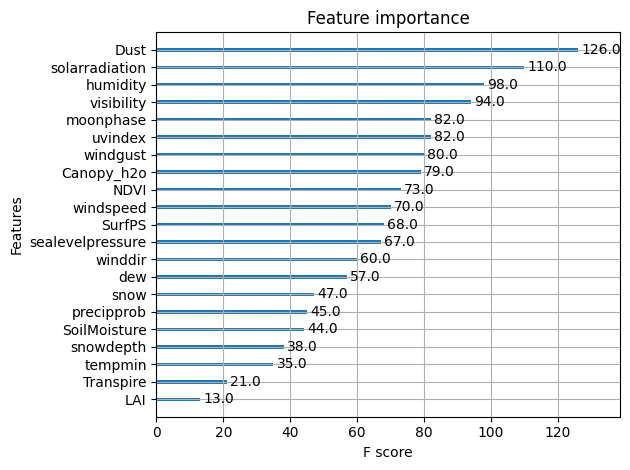

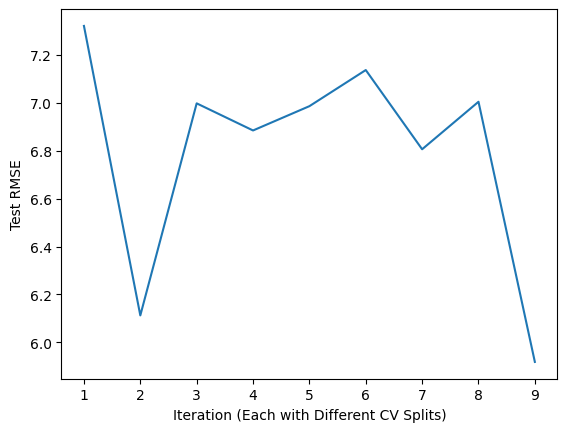

In [9]:
# We are using Denver data to train the model and testing on Columbus data

xgb_model_function(train_df = denver_df, test_df = columbus_df, predictor_vars = denver_predictors_fb)

{'objective': 'reg:squarederror', 'base_score': None, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 1, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 20, 'max_leaves': None, 'min_child_weight': 10, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 600, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': 0.5, 'reg_lambda': 2, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


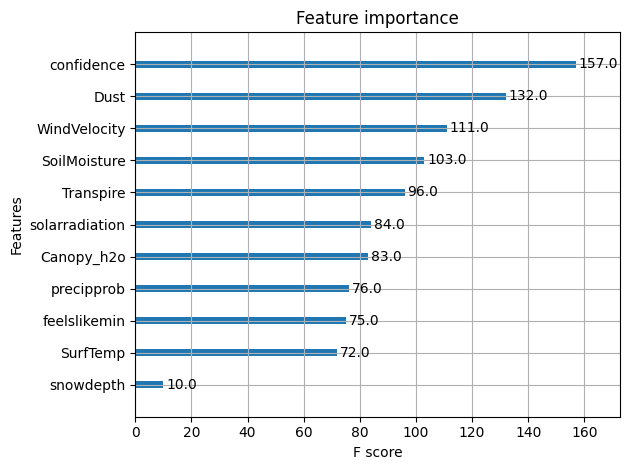

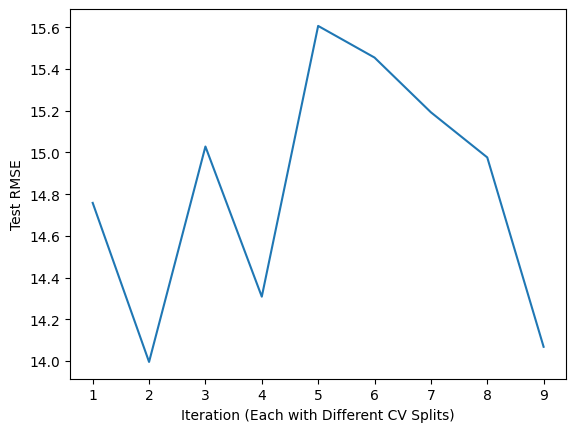

In [10]:
# We are using Columbus data to train the model and testing on Denver data

xgb_model_function(train_df = columbus_df, test_df = denver_df, predictor_vars = columbus_predictors_fb)